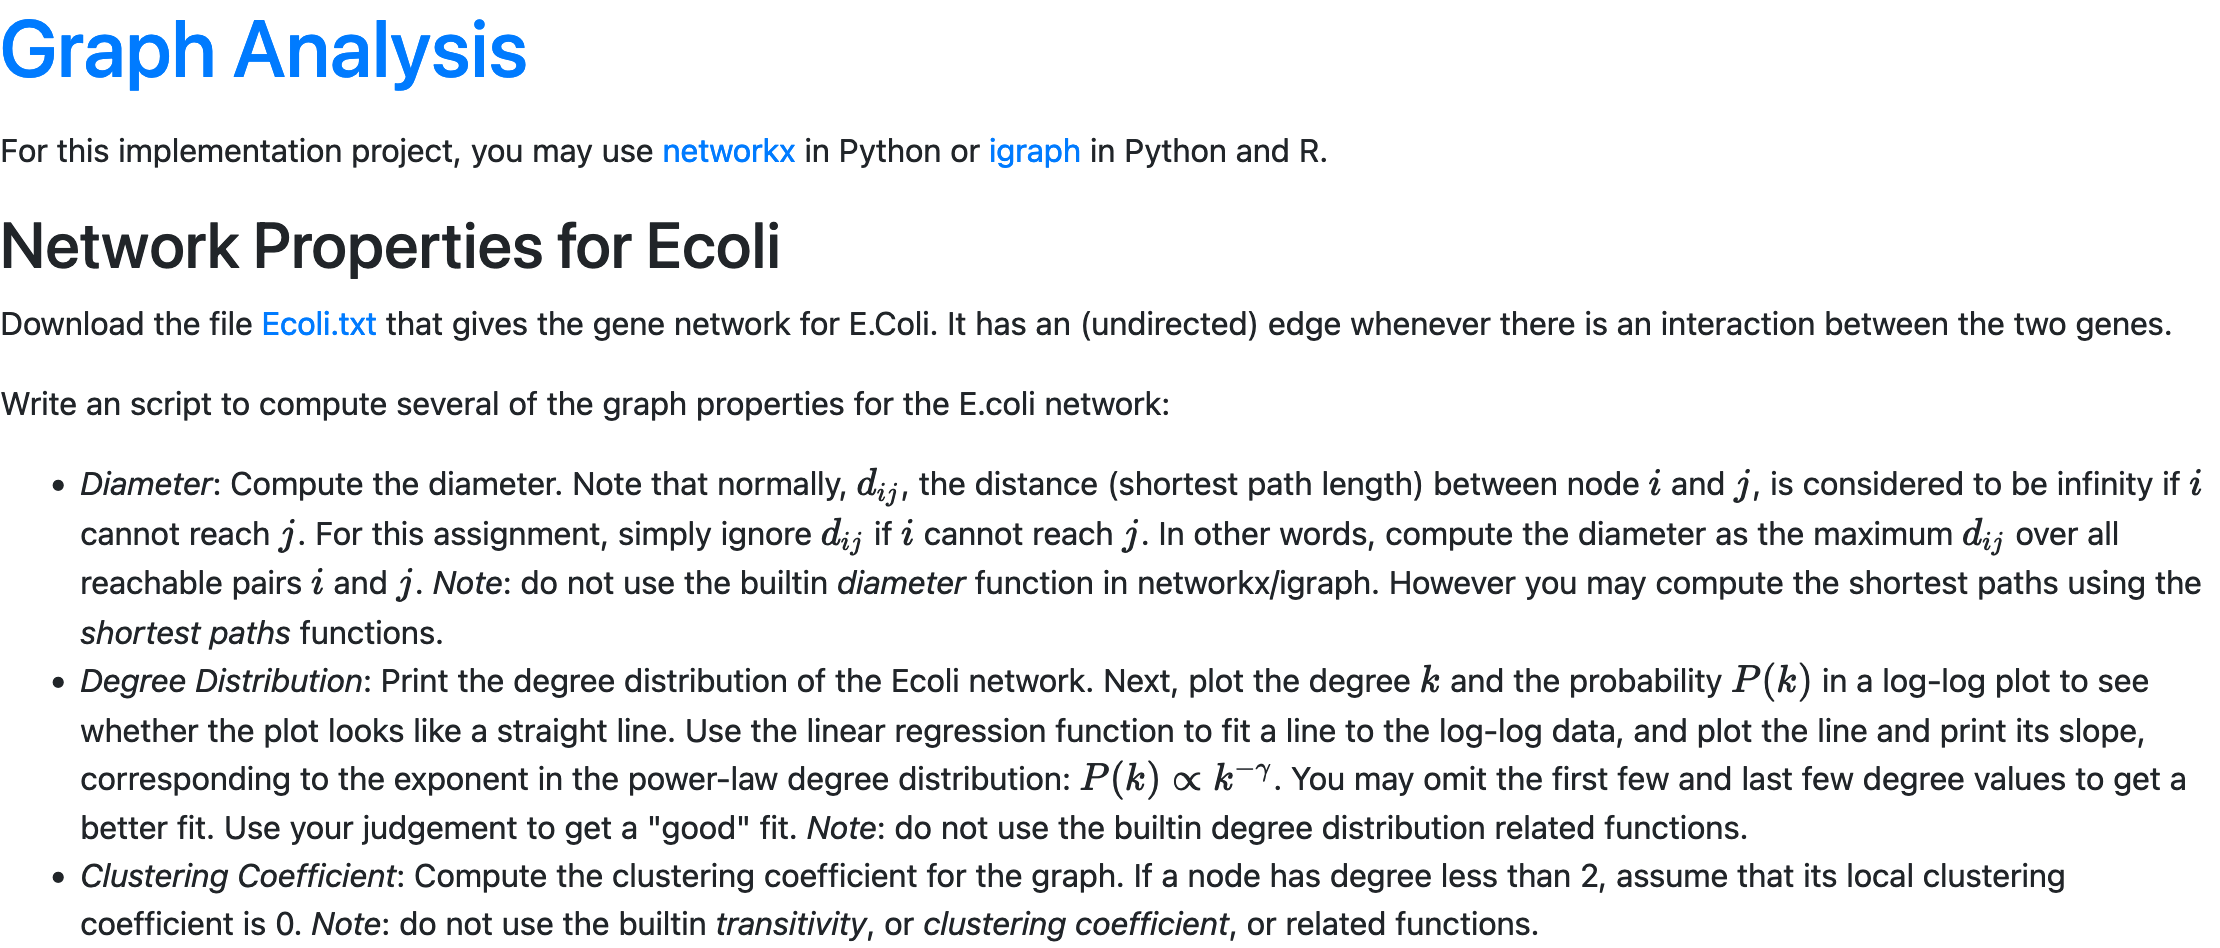
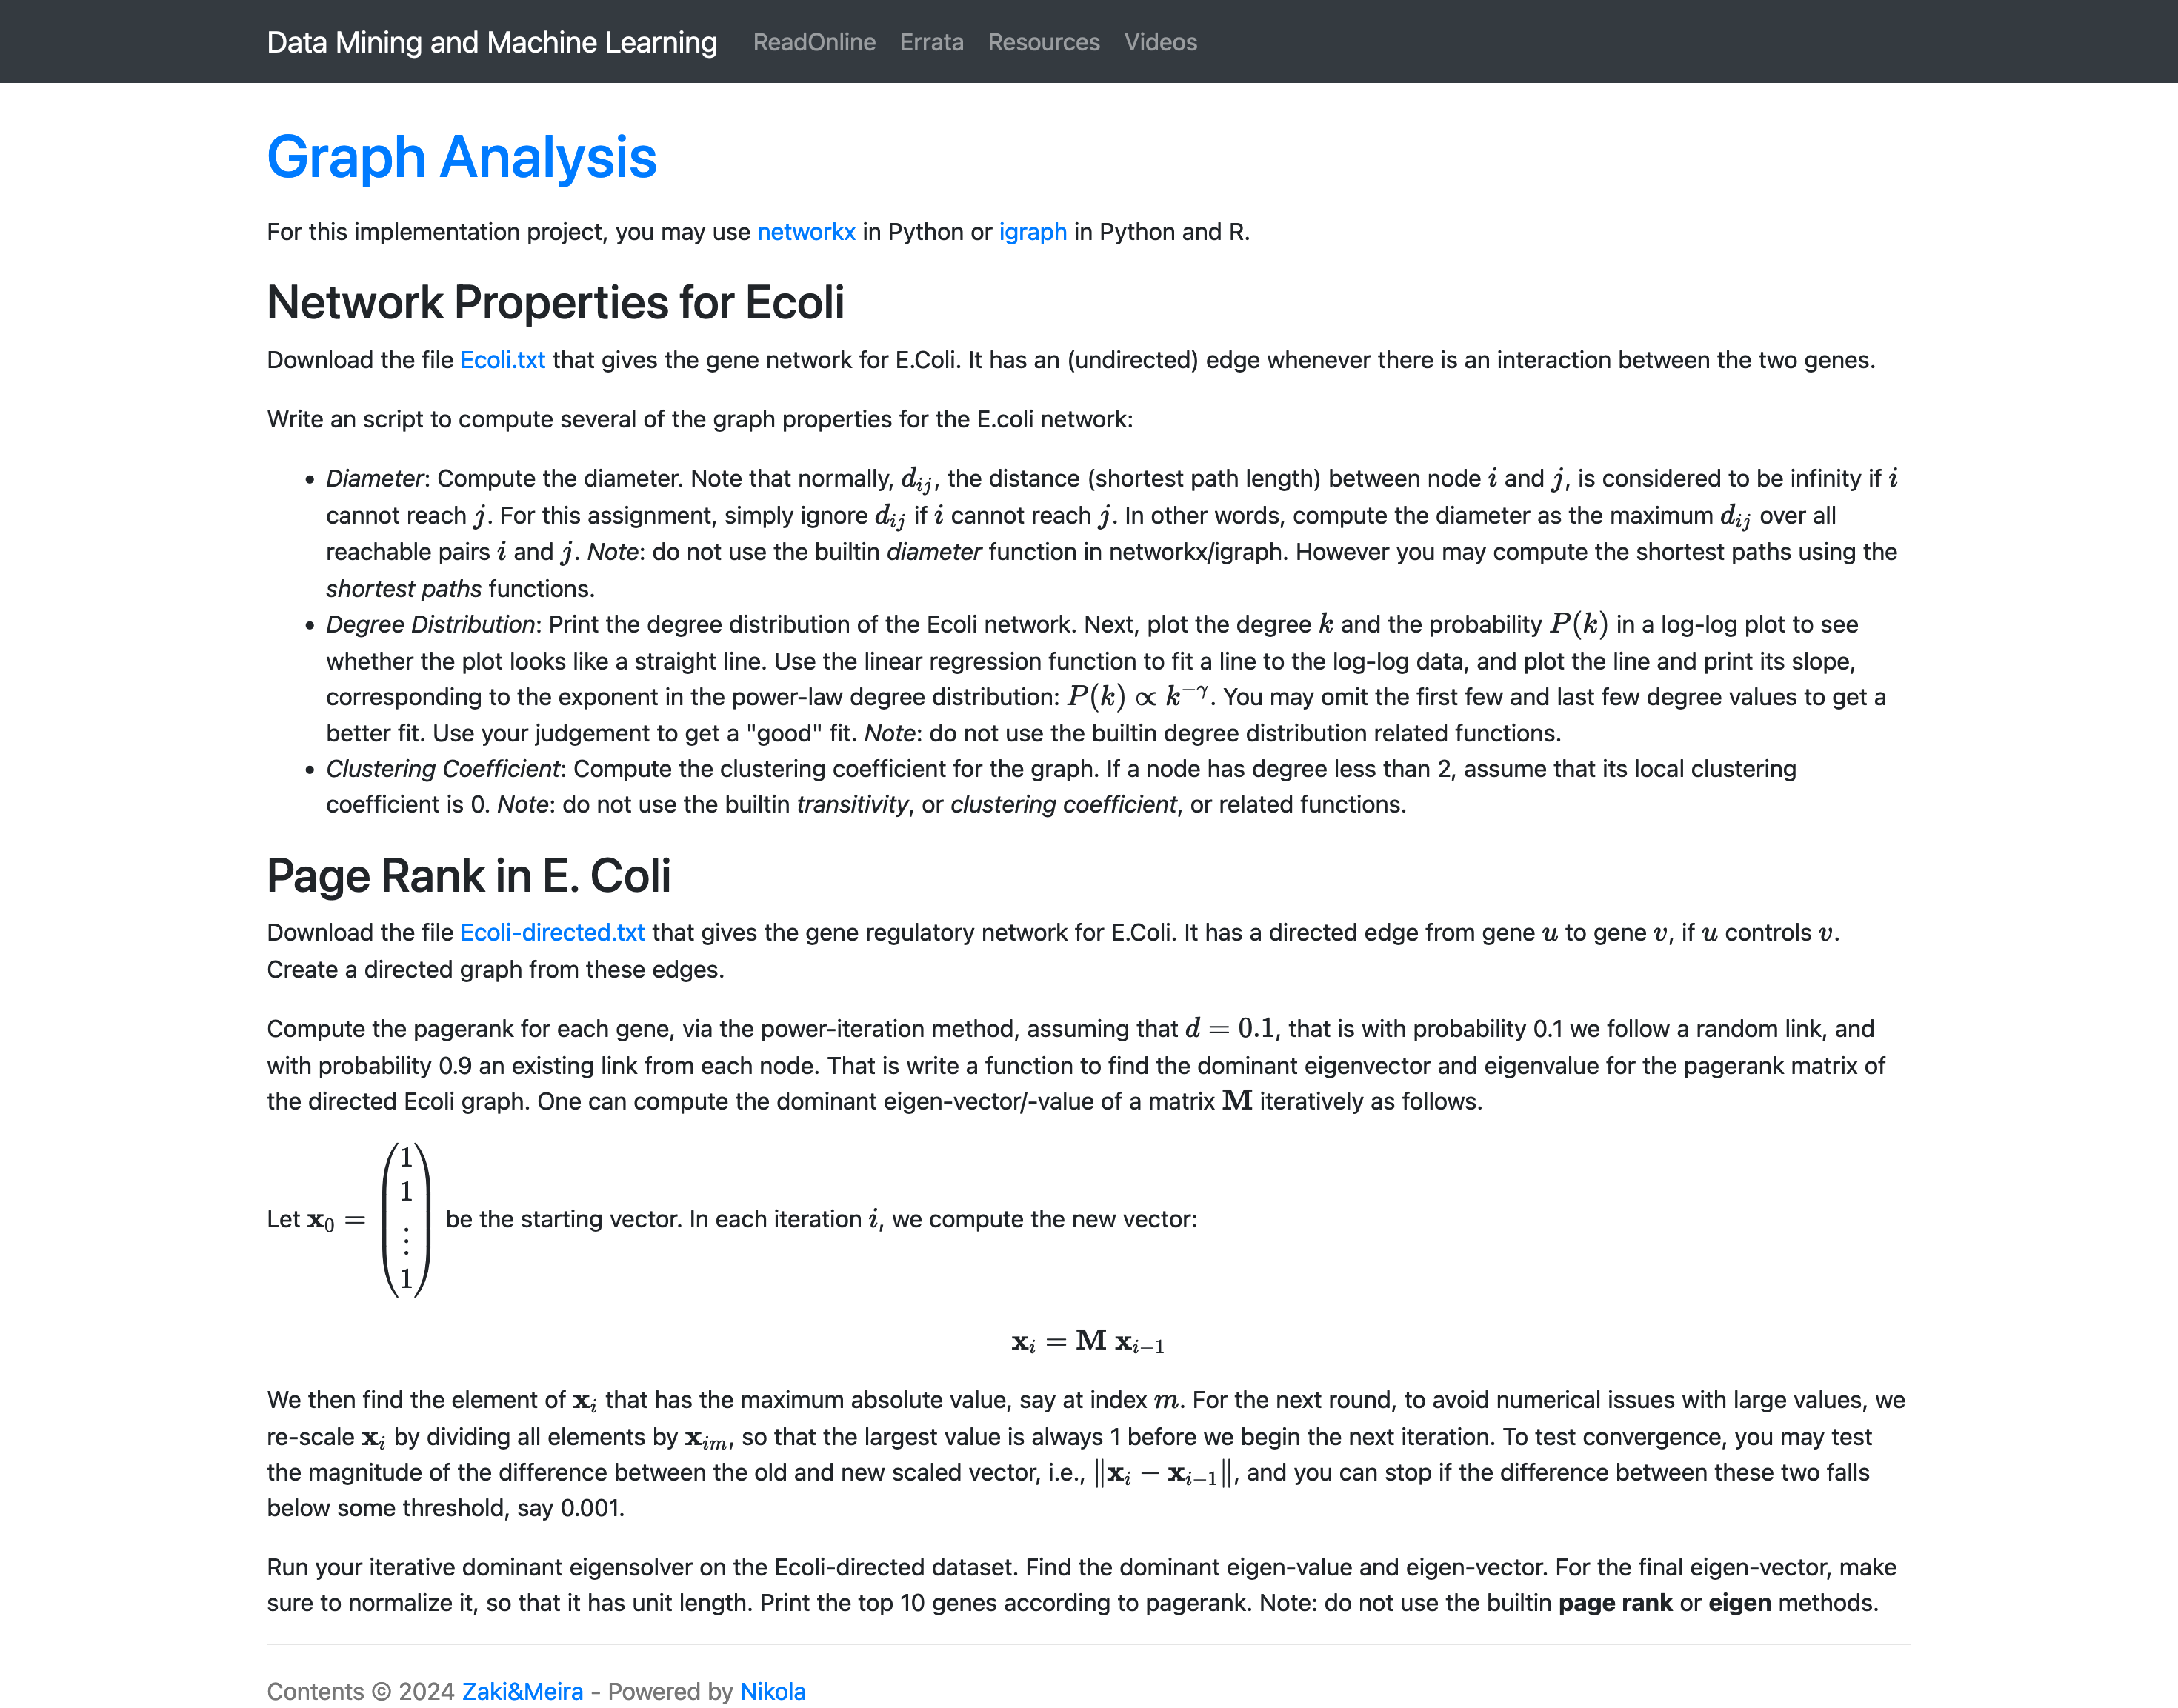

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
G = nx.read_adjlist('data/Ecoli.txt', nodetype=int)

In [3]:
G.number_of_edges()

3633

In [4]:
G.number_of_nodes()

1565

## Diameter

### Using builtin funtion

In [5]:
%%timeit -r 1 -n 1 
diameter = -1
for component in nx.connected_components(G):
    diameter = max(diameter, nx.diameter(G.subgraph(component)))

print(diameter)

9
3.62 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Manual

In [6]:
diameter = -1
for component in nx.connected_components(G):
    subgraph = G.subgraph(component)
    for i in component:
        for j in component:
            if i != j:
                path_length = len(nx.shortest_path(subgraph, i, j)) - 1
                diameter = max(diameter, path_length)
diameter

9

### Degree Distribution

In [7]:
distribution = dict()
total_nodes = G.number_of_nodes()

for node, degree in G.degree():
    distribution.setdefault(degree, 0)
    distribution[degree] += 1

for degree in distribution:
    distribution[degree] /= total_nodes

distribution

{3: 0.1412140575079872,
 7: 0.019808306709265176,
 11: 0.008306709265175719,
 33: 0.0019169329073482429,
 2: 0.2268370607028754,
 18: 0.0006389776357827476,
 4: 0.09520766773162939,
 34: 0.0012779552715654952,
 19: 0.0006389776357827476,
 139: 0.0006389776357827476,
 97: 0.0006389776357827476,
 216: 0.0006389776357827476,
 217: 0.0006389776357827476,
 1: 0.3539936102236422,
 8: 0.008306709265175719,
 430: 0.0006389776357827476,
 10: 0.003194888178913738,
 5: 0.03642172523961661,
 6: 0.06261980830670927,
 157: 0.0006389776357827476,
 221: 0.0006389776357827476,
 115: 0.0006389776357827476,
 25: 0.0012779552715654952,
 49: 0.0006389776357827476,
 277: 0.0006389776357827476,
 30: 0.0006389776357827476,
 9: 0.011501597444089457,
 40: 0.0006389776357827476,
 20: 0.0012779552715654952,
 87: 0.0006389776357827476,
 14: 0.0012779552715654952,
 16: 0.0012779552715654952,
 90: 0.0012779552715654952,
 83: 0.0006389776357827476,
 46: 0.0006389776357827476,
 15: 0.0019169329073482429,
 45: 0.000638

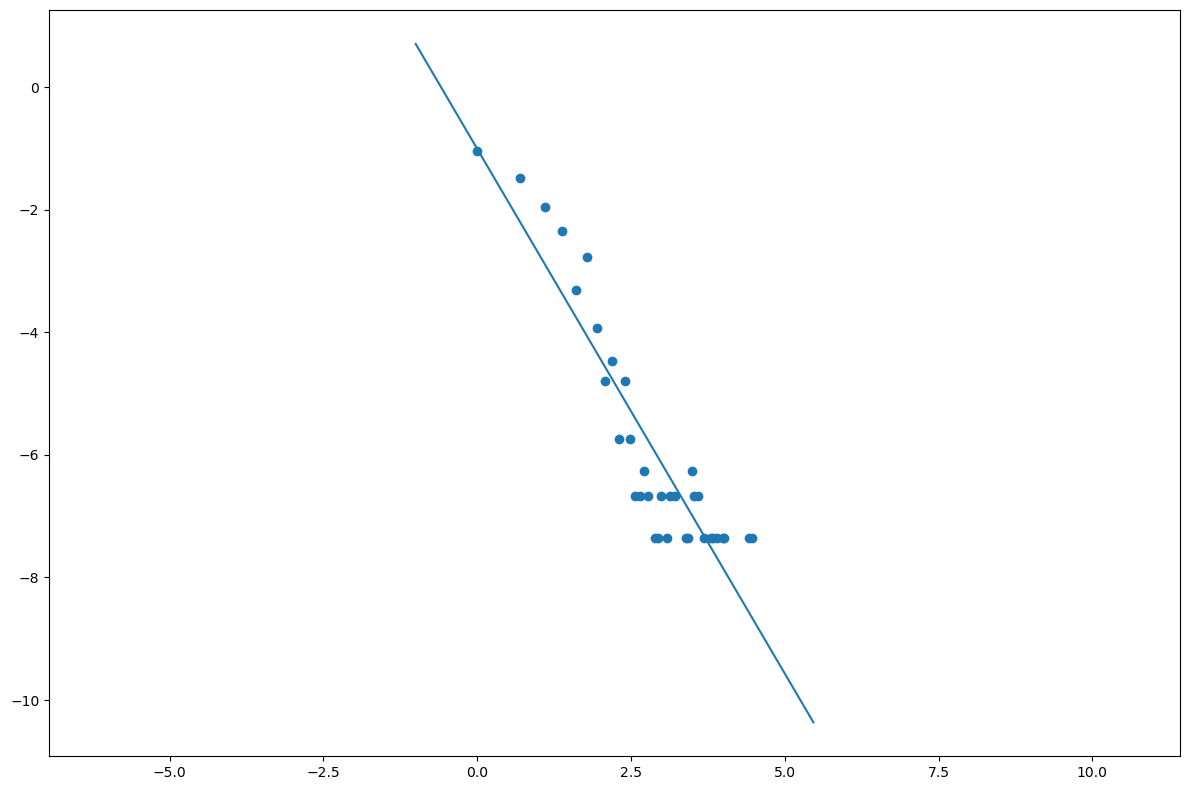

In [8]:
degrees, freq = zip(*sorted(list(distribution.items()), key=lambda x: x[0]))

# omit last 10 values
degrees = degrees[:-10]
freq = freq[:-10]
log_deg = np.log(degrees)
log_freq = np.log(freq)

model = LinearRegression()
model.fit(log_deg[:, np.newaxis], log_freq)

x_range = np.linspace(log_deg.min() - 1, log_deg.max() + 1, 1000)
y_range = model.predict(x_range[:, np.newaxis])

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_range, y_range)
ax.scatter(log_deg, log_freq)
ax.axis('equal')

plt.tight_layout()
plt.show()

In [9]:
gamma = -model.intercept_
gamma

1.005116056864761

## Clustering Coefficient

### Using builtin funtion

In [10]:
coefficient = nx.average_clustering(G)
coefficient

0.2116414939186282

### Manual

In [11]:
coefficient = 0

for node in G.nodes():
    if G.degree(node) >= 2:
        num_adjacent = G.degree[node]
        max_num_edges = num_adjacent * (num_adjacent - 1) / 2
        real_num_edges = len(nx.subgraph(G, nx.neighbors(G, node)).edges)
        coefficient += real_num_edges / max_num_edges

coefficient /= total_nodes
coefficient

0.2116414939186282

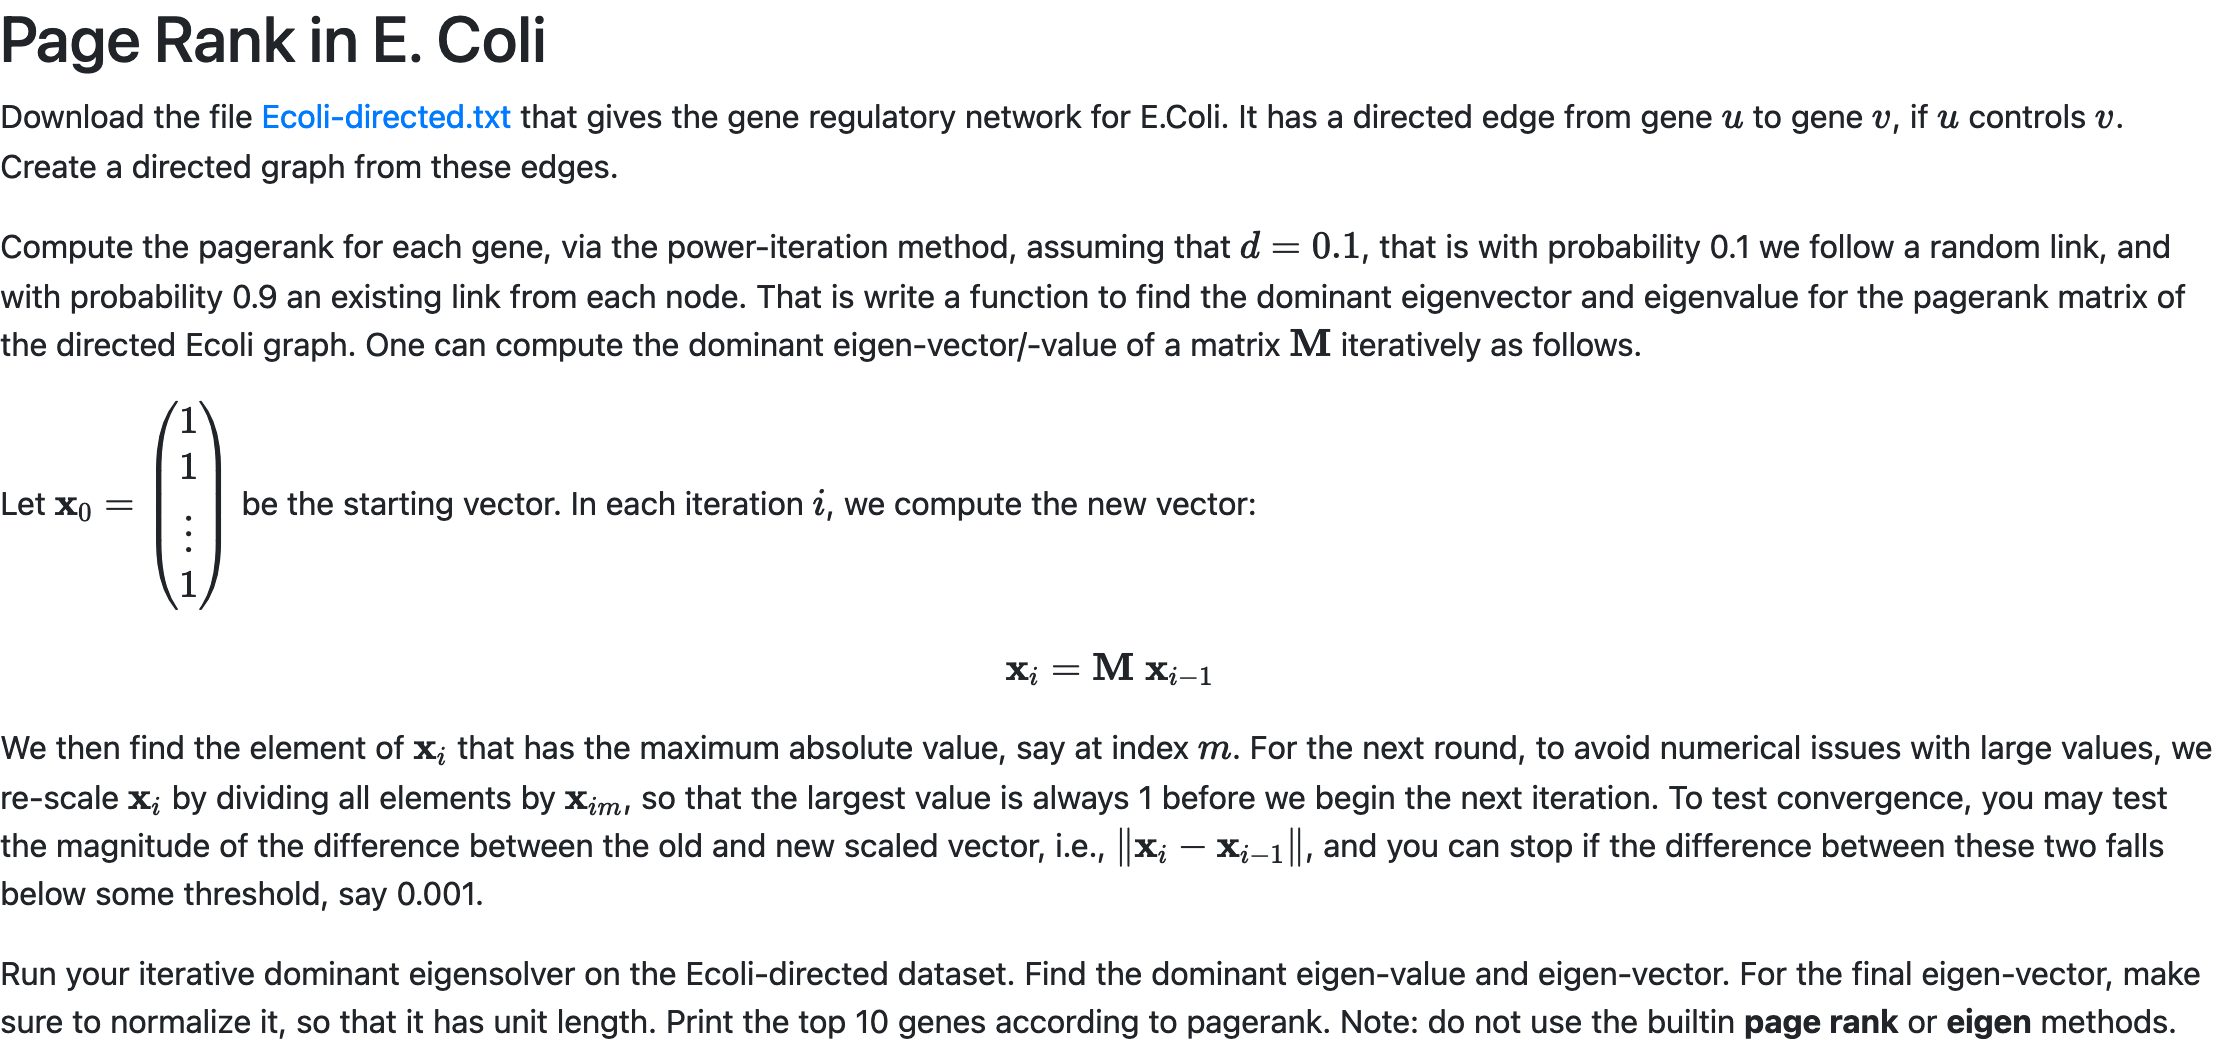

In [12]:
G = nx.read_adjlist('data/Ecoli-directed.txt', nodetype=int, create_using=nx.DiGraph)

In [13]:
def is_adjacent(i, j):
    return float(j in G[i])

In [14]:
n = G.number_of_nodes()
d = 0.1

Nr = np.ones((n, n)) / n
N = np.fromfunction(np.vectorize(is_adjacent), shape=(n, n))
cond = N.sum(axis=1) > 0
N[cond] /= N[cond].sum(axis=1).reshape((-1, 1))
N[~cond] = 1 / n

M = (1-d) * N + d * Nr

pr = np.ones(n)
while True:
    pr_new = M.T @ pr
    pr_new /= pr_new.max() # prevent overflow
    if np.linalg.norm(pr_new - pr) <= 0.001:
        pr = pr_new
        break
    pr = pr_new

pr /= np.linalg.norm(pr)

In [15]:
print(f"Top 10 gene: {pr.argsort()[-10:]}")

Top 10 gene: [ 478  681 1354 1353 1555 1556   19 1155 1154  978]
